In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

from tqdm.notebook import tqdm # progress bar


In [21]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


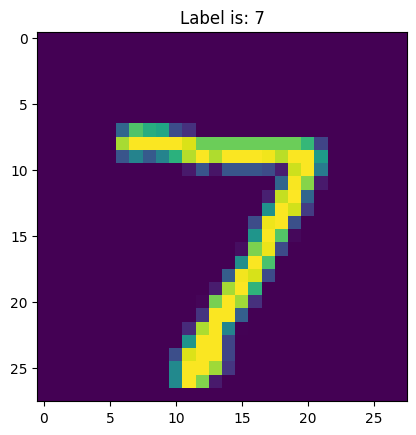

In [22]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    plt.imshow(X[0][0])
    
    plt.title(f"Label is: {y[0]}")
    plt.show()
    
    break



In [23]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


## Model

In [24]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim) # mean of the latent Gaussian distribution
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # log-variance of the latent Gaussian distribution

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [25]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


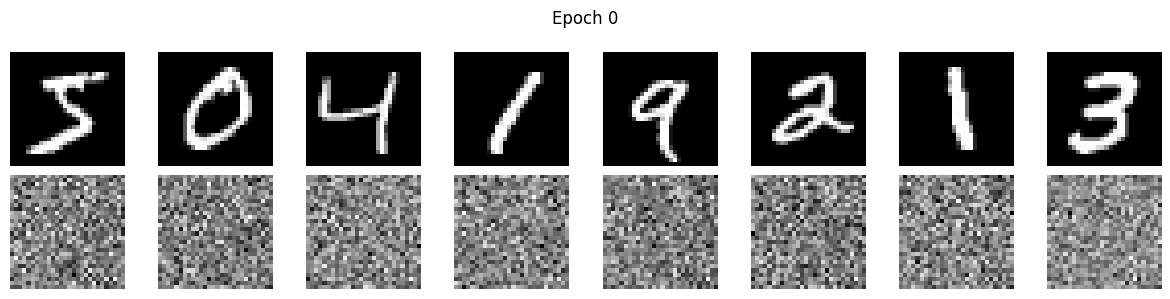

Epoch 0, Loss: 152.3727


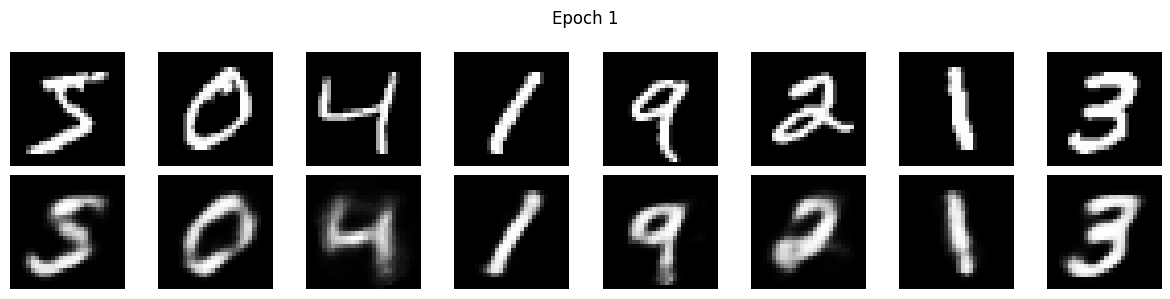

Epoch 1, Loss: 118.0872


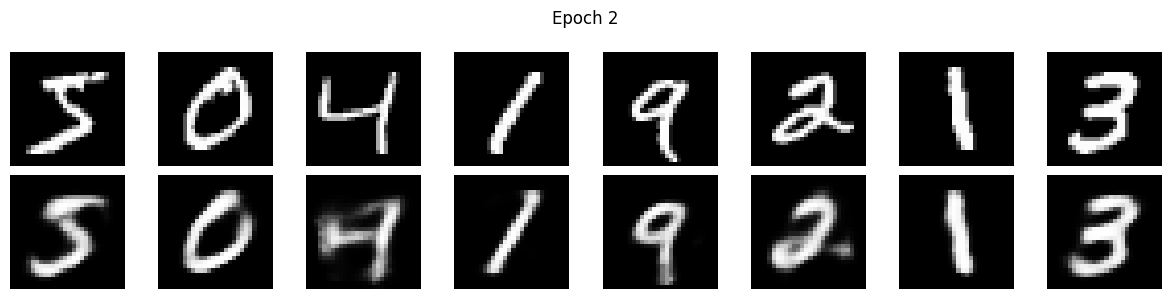

Epoch 2, Loss: 112.4466


In [28]:
# Data

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(3):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Visualize input vs reconstruction (for first batch only)
        if batch_idx == 0:
            n = min(data.size(0), 8)
            fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 3))
            for i in range(n):
                axes[0, i].imshow(data[i].squeeze().cpu().numpy(), cmap='gray')
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_batch[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
                axes[1, i].axis('off')
            axes[0, 0].set_ylabel('Input', fontsize=12)
            axes[1, 0].set_ylabel('Output', fontsize=12)
            plt.suptitle(f'Epoch {epoch}')
            plt.tight_layout()
            plt.show()


    print(f'Epoch {epoch}, Loss: {train_loss / len(train_dataloader.dataset):.4f}')
